# Pool-based Active Learning for Regression - Getting Started
This notebook gives on overview over some query strategies for active learning in
regression.

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from skactiveml.pool.regression import GSx, GSy, QueryByCommittee, \
    KullbackLeiblerDivergenceMaximization, RD
from skactiveml.regressor.estimator import NormalInverseChiKernelEstimator
from skactiveml.utils import call_func, is_labeled
from skactiveml.visualization import gaussian_noise_generator_1d, sample_generator_1d

First, we generate a dataset. To do this we use the function
`sample_generator_1d` to generate samples from 0 to 2, with a higher
 density from 0.5 to 1.5. For each target value from our true function we
 add gaussian noise using `gaussian_noise_generator_1d`, where
 we specify to add further noise in the region from 0 to 1.

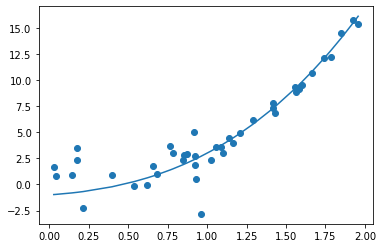

In [5]:
def true_function(X):
    x = X.flatten()
    return x**3 + 2*x**2 + x - 1

x_low, x_up = 0, 2
random_state = 0
n_samples = 42
n_iterations = 15

def noise_gen(X):
    return gaussian_noise_generator_1d(X, (0, 1, 2), random_state=random_state)

def sample_gen(n):
    return sample_generator_1d(n, (x_low, x_up), (0.0, 1.5), random_state=random_state)

X = sample_gen(n_samples)
X_test = np.linspace(x_low, x_up, num=100).reshape(-1, 1)

y_true = true_function(X) + noise_gen(X)

plt.scatter(X, y_true)
plt.plot(X, true_function(X))
plt.show()

Now we want to look at how the different query strategies determine
which sample to query. We do so by looking at the utility assigned by
each query strategy for querying a samples. The assigned utility is displayed
by the light blue line matching the axis to the right. The unlabeled samples
are green, the already labeled samples are orange, and the samples selected
to be queried next is red. The model prediction, build by the orange samples, are
displayed in dark blue.

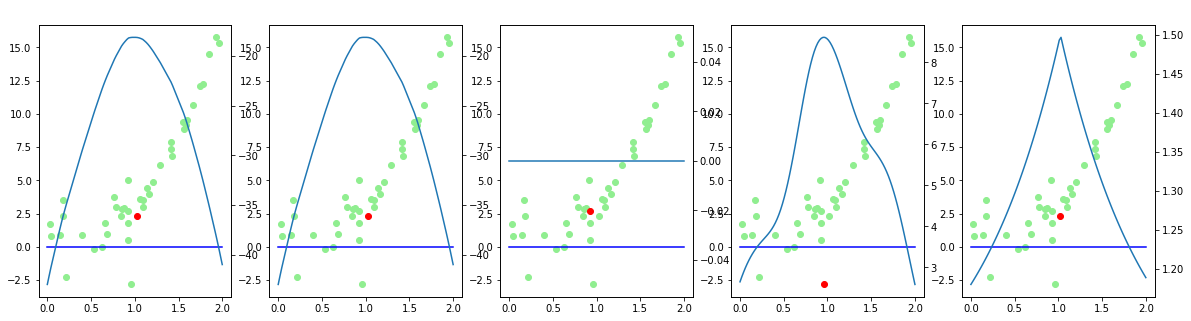

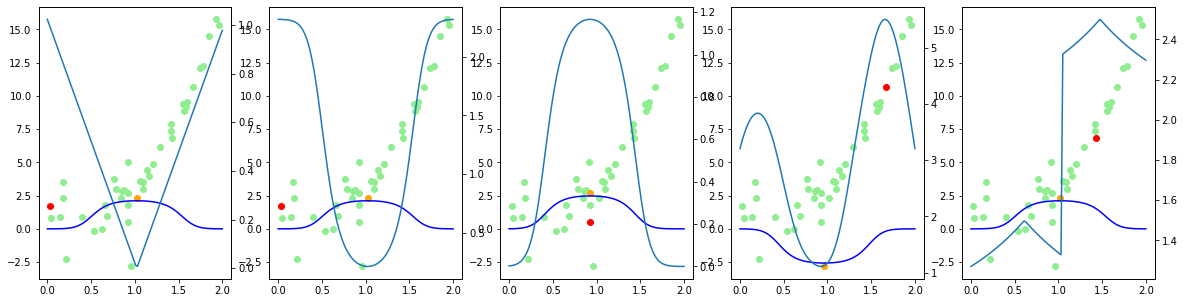

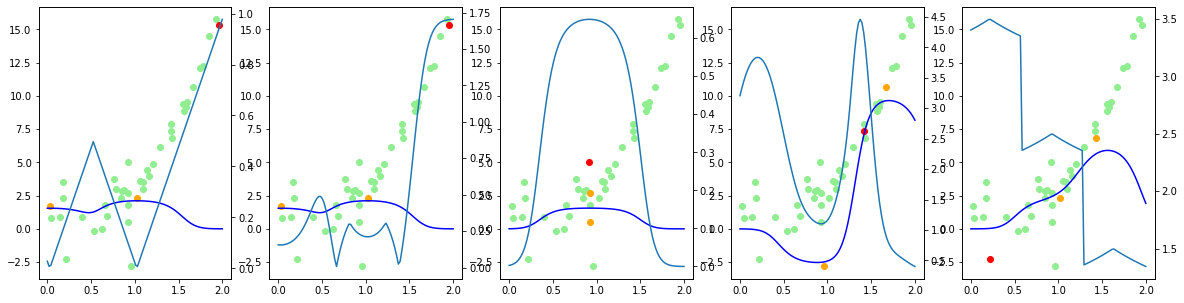

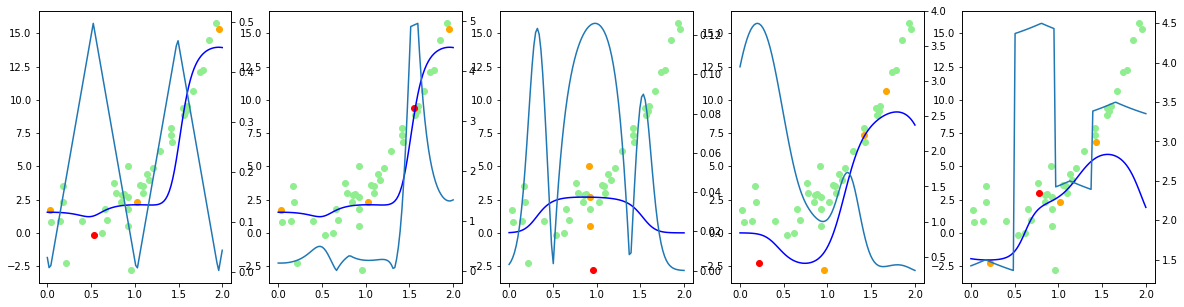

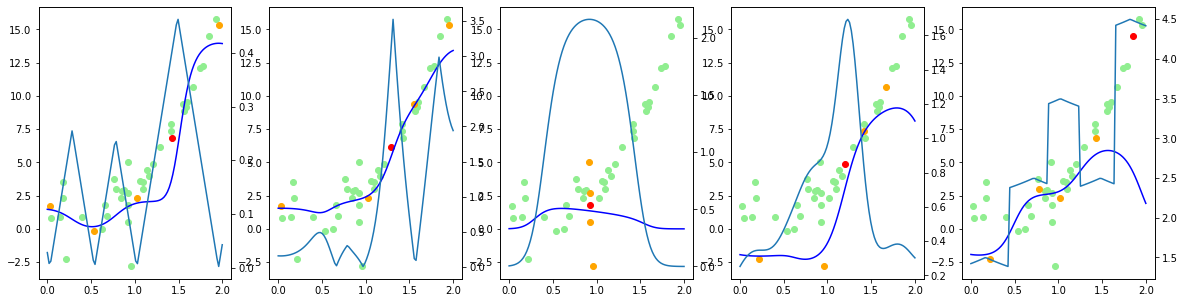

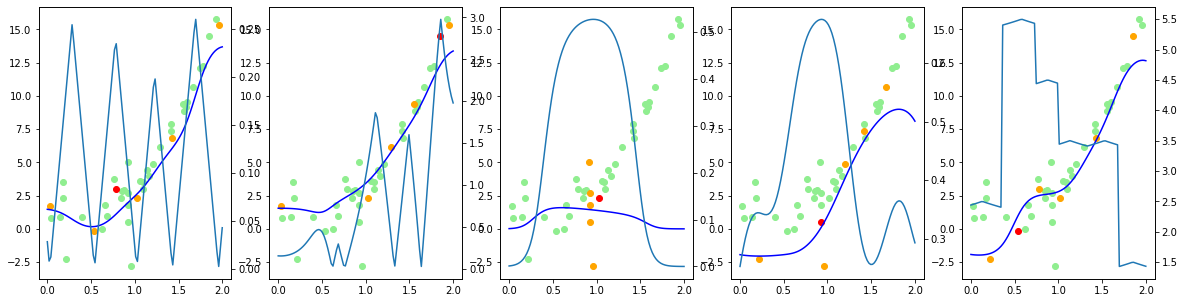

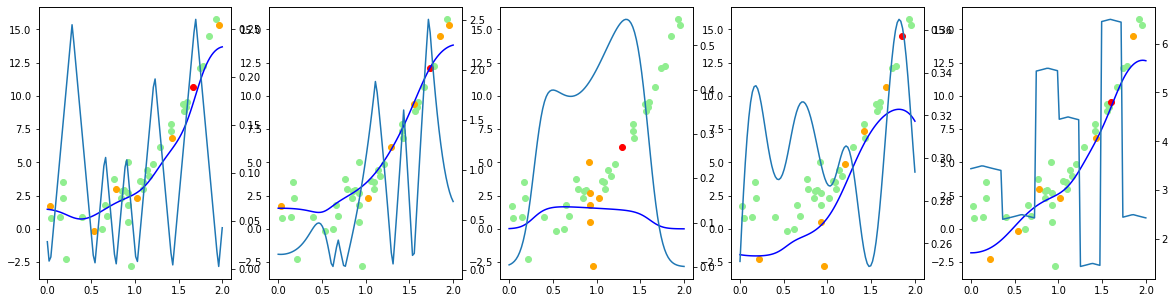

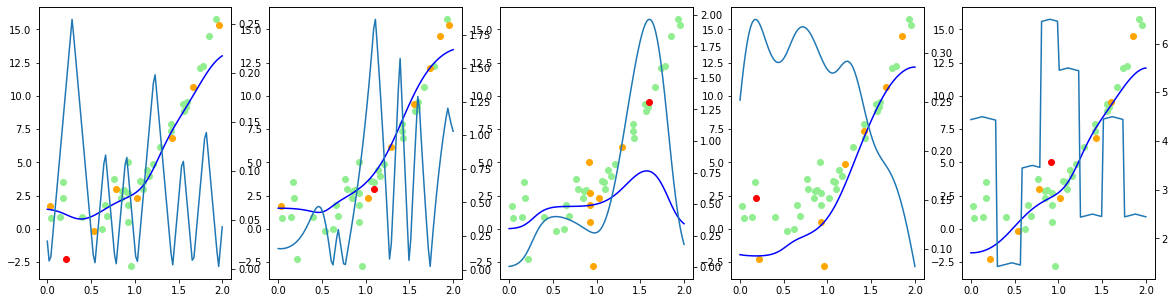

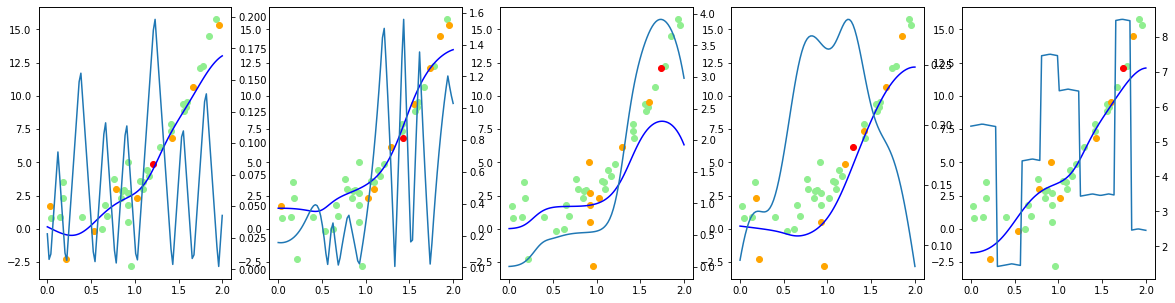

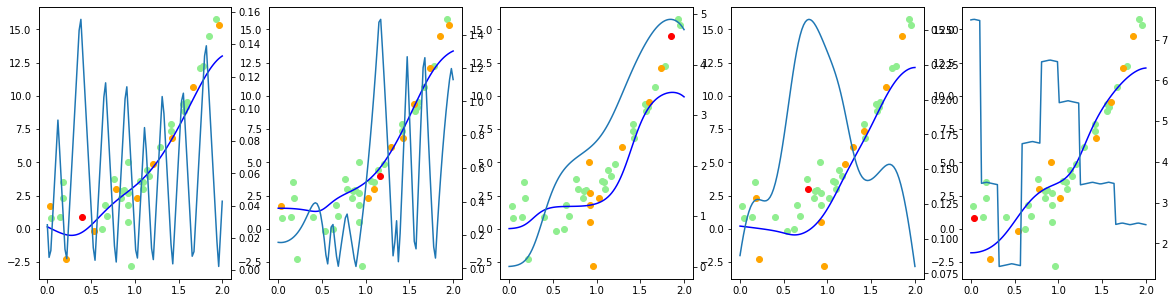

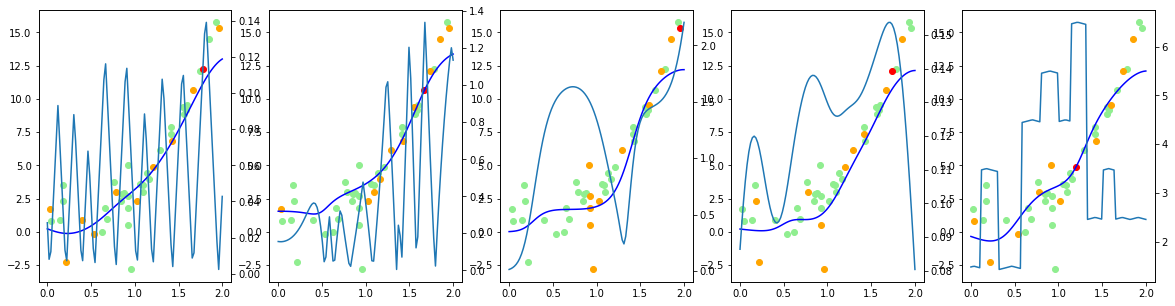

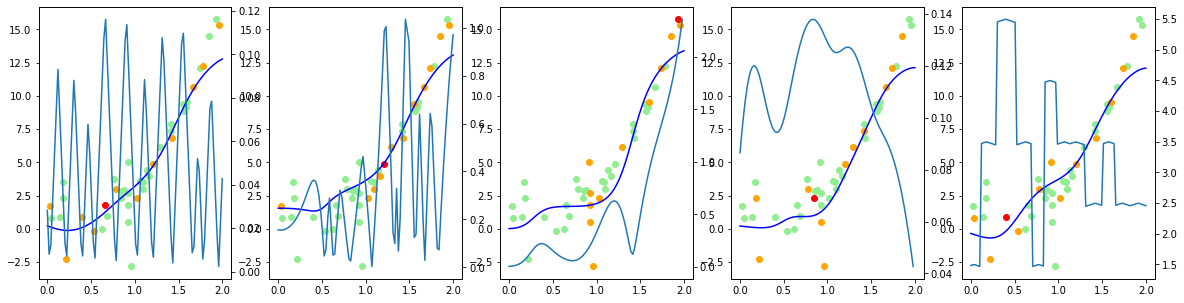

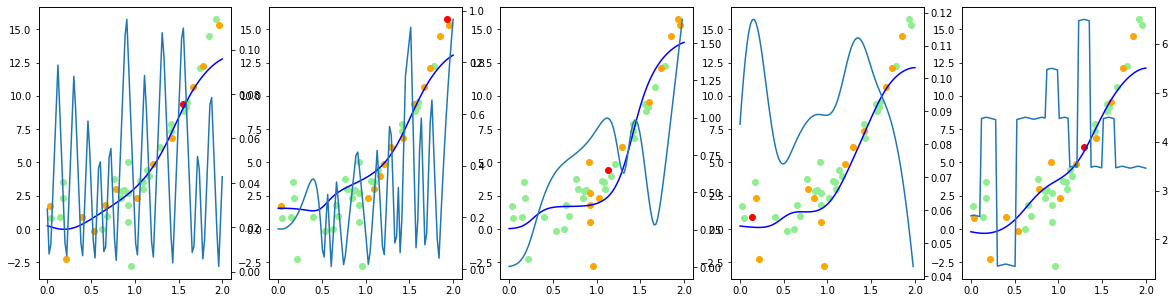

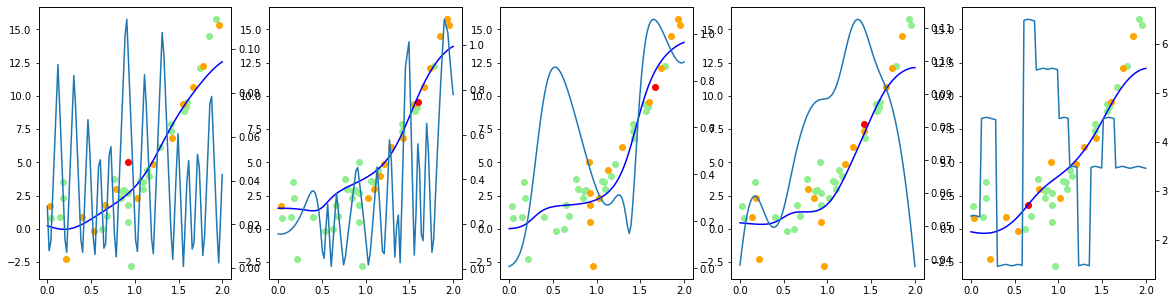

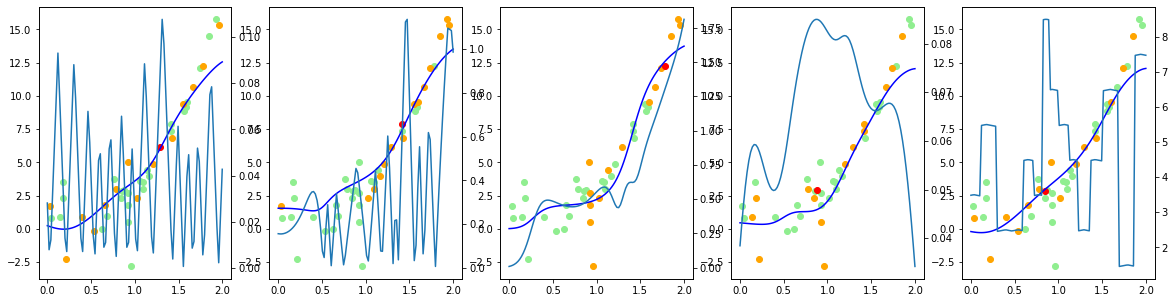

In [6]:
qs_s = [
    GSx(random_state=random_state),
    GSy(random_state=random_state),
    QueryByCommittee(random_state=random_state),
    KullbackLeiblerDivergenceMaximization(random_state=random_state,
                                          integration_dict_cross_entropy={'method':'quantile',
                                                                          'n_integration_samples':50}),
    RD(random_state=random_state)
]

y = np.full_like(y_true, np.nan)
y_s = [y.copy() for _ in range(len(qs_s))]

cond_est = NormalInverseChiKernelEstimator(metric_dict={'gamma': 10.0})

for i in range(n_iterations):
    fig, axes = plt.subplots(1, len(qs_s), figsize=(20, 5))
    axes = [axes, ] if len(qs_s)==1 else axes

    for qs, ax, y in zip(qs_s, axes, y_s):
        cond_est.fit(X, y)
        indices, utils = call_func(qs.query,
            X=X,
            y=y,
            cond_est=cond_est,
            reg=cond_est,
            ensemble=cond_est,
            fit_cond_est=True,
            return_utilities=True,
        )
        _, utilities_test = call_func(qs.query,
            X=X,
            y=y,
            cond_est=cond_est,
            reg=cond_est,
            ensemble=cond_est,
            candidates=X_test,
            fit_cond_est=True,
            return_utilities=True,
        )
        y_old = y.copy()
        y[indices] = y_true[indices]
        is_lbld = is_labeled(y)
        old_is_lbld = is_labeled(y_old)
        ax_t = ax.twinx()
        #ax_t.scatter(X[~old_is_lbld], utils.flatten()[~old_is_lbld])
        utilities_test_flat = utilities_test.flatten()
        std_utilities_test_flat = np.std(utilities_test_flat)
        mean_utilities_test_flat = np.mean(utilities_test_flat)
        is_in_range = np.abs(mean_utilities_test_flat-utilities_test_flat) <= 3 * std_utilities_test_flat
        ax_t.plot(X_test[is_in_range], utilities_test_flat[is_in_range])

        ax.scatter(X[~is_lbld], y_true[~is_lbld], c='lightgreen')
        ax.scatter(X[old_is_lbld], y[old_is_lbld], c='orange')
        ax.scatter(X[indices], y[indices], c='red')

        y_pred, y_std = cond_est.predict(X_test, return_std=True)
        ax.plot(X_test, y_pred, c='blue')
        if i == 0:
            ax.set_title(qs.__class__.__name__, fontdict={'fontsize': 15, 'color': 'white'})
    plt.show()
